In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from bisect import bisect
import seaborn as sns

from dandi.dandiapi import DandiAPIClient
from collections import defaultdict

In [2]:
sns.set_context("talk")

In [3]:
client = DandiAPIClient()

dandisets = list(client.get_dandisets())

species_replacement = {
    "Mus musculus - House mouse": "House mouse",
    "Rattus norvegicus - Norway rat": "Rat",
    "Brown rat": "Rat",
    "Rat; norway rat; rats; brown rat": "Rat",
    "Homo sapiens - Human": "Human",
    "Drosophila melanogaster - Fruit fly": "Fruit fly",
}

neurodata_type_map = dict(
    ecephys=["LFP", "Units", "ElectricalSeries"],
    ophys=["PlaneSegmentation", "TwoPhotonSeries", "ImageSegmentation"],
    icephys=["PatchClampSeries", "VoltageClampSeries", "CurrentClampSeries"],
)

def is_nwb(metadata):
    return any(
        x['identifier'] == 'RRID:SCR_015242'
        for x in metadata['assetsSummary'].get('dataStandard', {})
    )

data = defaultdict(list)
for dandiset in dandisets:
    identifier = dandiset.identifier
    metadata = dandiset.get_raw_metadata()
    if not is_nwb(metadata) or not dandiset.draft_version.size:
        continue
    data["identifier"].append(identifier)
    data["created"].append(dandiset.created)
    data["size"].append(dandiset.draft_version.size)
    if "species" in metadata["assetsSummary"] and len(metadata["assetsSummary"]["species"]):
        data["species"].append(metadata["assetsSummary"]["species"][0]["name"])
    else:
        data["species"].append(np.nan)
    
    
    for modality, ndtypes in neurodata_type_map.items():
        data[modality].append(
            any(x in ndtypes for x in metadata["assetsSummary"]["variableMeasured"])
        )
    
    if "numberOfSubjects" in metadata["assetsSummary"]:
        data["numberOfSubjects"].append(metadata["assetsSummary"]["numberOfSubjects"])
    else:
        data["numberOfSubjects"].append(np.nan)
    
df = pd.DataFrame.from_dict(data)

for key, val in species_replacement.items():
    df["species"] = df["species"].replace(key, val)

df

,identifier,created,size,species,ecephys,ophys,icephys,numberOfSubjects
0,000003,2020-03-15 22:56:55.655000+00:00,2559248010229,House mouse,True,False,False,16.0
1,000004,2020-03-16 21:48:04.265000+00:00,6197474020,Human,True,False,False,59.0
2,000005,2020-03-16 22:52:44.757000+00:00,46436686324,House mouse,True,False,True,55.0
3,000006,2020-03-17 13:30:38.667000+00:00,139600500,House mouse,True,False,False,12.0
4,000007,2020-03-17 15:01:40.811000+00:00,199439472,House mouse,True,False,False,13.0
...,...,...,...,...,...,...,...,...
93,000249,2022-05-18 13:58:54.819909+00:00,97968237237,House mouse,False,True,False,54.0
94,000251,2022-05-23 20:41:16.503656+00:00,2175642248,House mouse,True,False,False,53.0
95,000288,2022-06-28 06:19:13.950846+00:00,1049737334,Human,False,False,True,12.0
96,000292,2022-07-07 21:28:23.171592+00:00,13764872,House mouse,False,False,True,11.0


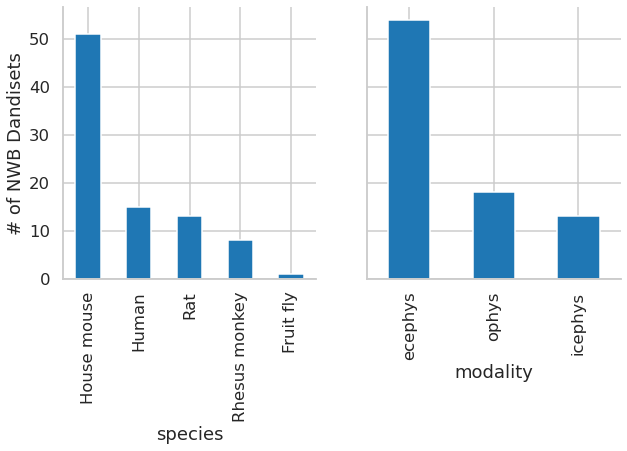

In [14]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

plt.axes(axs[0])                      
ax = df["species"].value_counts().plot.bar()
ax.set_ylabel("# of NWB Dandisets")
ax.set_xlabel("species")
sns.despine()

plt.axes(axs[1])
ax = df[["ecephys", "ophys", "icephys"]].sum().plot.bar()
ax.set_xlabel("modality")
sns.despine()

ax.figure.savefig("species-modality.png", bbox_inches="tight")

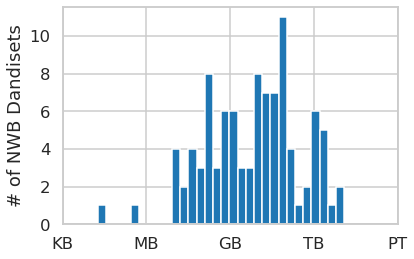

In [16]:
logsize = np.log10(df["size"])
#logsize[logsize < 0] = np.nan

ax = logsize.plot.hist(bins=30)
ax.set_xticks([3, 6, 9, 12, 15])
ax.set_ylabel("# of NWB Dandisets")
ax.set_xticklabels(["KB", "MB", "GB", "TB", "PT"])
ax.figure.savefig("size.png", bbox_inches="tight")

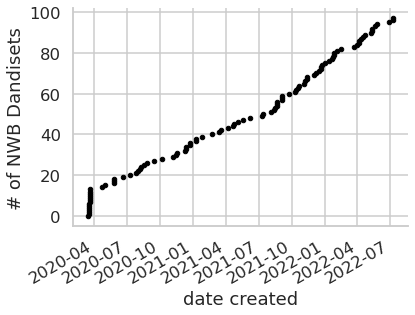

In [17]:
fig, ax = plt.subplots()

ax.plot(df['created'], np.arange(len(df)), 'k.')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel('# of NWB Dandisets')
ax.set_xlabel("date created")
sns.despine()
ax.figure.savefig("date.png", bbox_inches="tight")

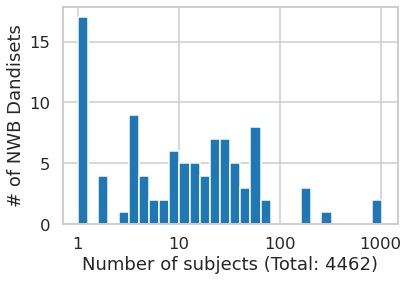

In [26]:
lognum = np.log10(df["numberOfSubjects"])


ax = lognum.plot.hist(bins=30)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([1, 10, 100, 1000])
ax.set_ylabel('# of NWB Dandisets')

ax.set_xlabel(f"Number of subjects (Total: {df['numberOfSubjects'].sum().astype(int)})")
ax.figure.savefig("subjects.png", bbox_inches="tight")